In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
base_dir='/content/drive/MyDrive/Brain tumor detection dataset'

In [5]:
test_dir='/content/drive/MyDrive/Brain tumor detection dataset/Testing'
train_dir='/content/drive/MyDrive/Brain tumor detection dataset/Training'

In [ ]:
!pip install tensorflow

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img
from sklearn.utils import shuffle

In [ ]:
SAVE = False
SEED = 42

In [ ]:
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

In [ ]:
train_paths = []
train_labels = []

for label in os.listdir(train_dir):
    for image in os.listdir(os.path.join(train_dir, label)):
        train_paths.append(os.path.join(train_dir, label, image))
        train_labels.append(label)

train_paths, train_labels = shuffle(train_paths, train_labels)

test_paths = []
test_labels = []

for label in os.listdir(test_dir):
    for image in os.listdir(os.path.join(test_dir, label)):
        test_paths.append(os.path.join(test_dir, label, image))
        test_labels.append(label)

test_paths, test_labels = shuffle(test_paths, test_labels)

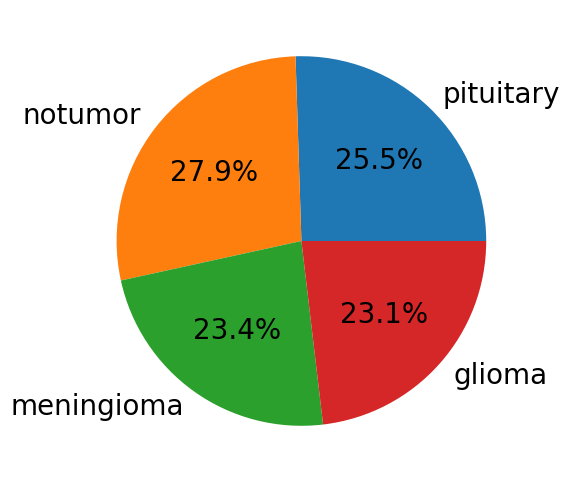

In [ ]:
plt.figure(figsize=(14,6))
plt.rcParams.update({'font.size': 20})
plt.pie([len([x for x in train_labels if x=='pituitary']),
         len([x for x in train_labels if x=='notumor']),
         len([x for x in train_labels if x=='meningioma']),
         len([x for x in train_labels if x=='glioma'])],
        labels=['pituitary','notumor', 'meningioma', 'glioma'],
        autopct='%.1f%%');


In [ ]:
image_size = (150, 150)
batch_size=32

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")



Found 5712 images belonging to 4 classes.
Found 1324 images belonging to 4 classes.


In [ ]:
# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)


In [ ]:
# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)

In [ ]:
def show_ImageDataGenerator(datagen, num_samples, figsize, save=False):

    plt.figure(figsize=figsize)
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)

        img = load_img(train_paths[np.random.randint(len(train_paths))])
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)
        # Generate one batch of augmented images
        augmented_images = datagen.flow(x, batch_size=1)
        # Display the first image from the batch
        plt.imshow(array_to_img(augmented_images[0][0]))
        plt.axis("off")
    plt.tight_layout()
    if save:
        plt.savefig("augmented_images.png")
    plt.show()

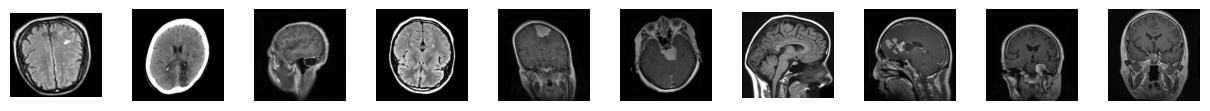

In [ ]:
show_ImageDataGenerator(train_datagen, num_samples=10, figsize=(12.5, 8), save=SAVE)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

base_model = VGG16(input_shape=(image_size[0], image_size[1], 3), include_top=False, weights='imagenet')

# Freeze all layers of the VGG16 base model
for layer in base_model.layers:
    layer.trainable = False

# Set the last few layers of the VGG16 base model to be trainable
base_model.layers[-2].trainable = True
base_model.layers[-3].trainable = True
base_model.layers[-4].trainable = True

In [ ]:
model = Sequential()
model.add(Input(shape=(image_size[0], image_size[1], 3)))  # Input layer
model.add(base_model)  # Add VGG16 base model
model.add(Flatten())  # Flatten the output of the base model
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(128, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.4))  # Dropout layer for regularization
model.add(Dense(64, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(32, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.3))  # Dropout layer for regularization
model.add(Dense(len(os.listdir(train_dir)), activation='softmax'))  # Output layer with softmax activation


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 4)              │           132 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,773,860 (60.17 MB)

 Trainable params: 8,138,596 (31.05 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

In [ ]:
plt.figure(figsize=(8, 8)) # You can adjust the size as needed
keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)
plt.show()

<Figure size 800x800 with 0 Axes>

In [ ]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy'])

# Parameters
batch_size = 25
steps = int(len(train_paths) / batch_size)  # Steps per epoch
epochs = 15

# Train the model
history = model.fit(train_generator,
                    epochs=epochs, steps_per_epoch=steps)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 1379s 6s/step - categorical_accuracy: 0.5129 - loss: 1.1141
Epoch 2/15


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


228/228 ━━━━━━━━━━━━━━━━━━━━ 62s 273ms/step - categorical_accuracy: 0.7929 - loss: 0.6012
Epoch 3/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 81s 270ms/step - categorical_accuracy: 0.8513 - loss: 0.4474
Epoch 4/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 82s 270ms/step - categorical_accuracy: 0.8814 - loss: 0.3587
Epoch 5/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 82s 270ms/step - categorical_accuracy: 0.8966 - loss: 0.3352
Epoch 6/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 82s 272ms/step - categorical_accuracy: 0.9226 - loss: 0.2623
Epoch 7/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 61s 269ms/step - categorical_accuracy: 0.9351 - loss: 0.2107
Epoch 8/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 82s 271ms/step - categorical_accuracy: 0.9351 - loss: 0.2035
Epoch 9/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 62s 272ms/step - categorical_accuracy: 0.9494 - loss: 0.1848
Epoch 10/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 61s 267ms/step - categorical_accuracy: 0.9579 - loss: 0.1321
Epoch 11/15
228/228 ━━━━━━━━━━━━━━━━━━━━ 82s 268ms/step - categorical_accuracy: 0.9694 - loss: 0.1119

In [ ]:
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

52/52 ━━━━━━━━━━━━━━━━━━━━ 393s 8s/step - categorical_accuracy: 0.9715 - loss: 0.0767 
Test Loss: 0.06162
Test Accuracy: 0.97659


In [6]:
_, ax = plt.subplots(ncols=2, figsize=(10, 6))

# Plot the training accuracy over epochs
ax[0].plot(history.history['categorical_accuracy'])
ax[0].set_title('Model Training Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train'])
ax[0].grid(alpha=0.2)

# Plot the training loss over epochs
ax[1].plot(history.history['loss'])
ax[1].set_title('Model Training Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train'])
ax[1].grid(alpha=0.2)

plt.show()

NameError: name 'plt' is not defined

In [ ]:
from sklearn.metrics import confusion_matrix as sk_confusion_matrix

def CM(CNN_model, test_generator, categories):
    y_true = test_generator.classes
    y_pred = np.argmax(CNN_model.predict(test_generator), axis=1)
    cm = sk_confusion_matrix(y_true, y_pred)
    return cm

# Get the class indices from the training generator
class_indices_train = train_generator.class_indices
class_indices_train_list = list(class_indices_train.keys())
N_TYPES = len(class_indices_train_list)

42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 174ms/step


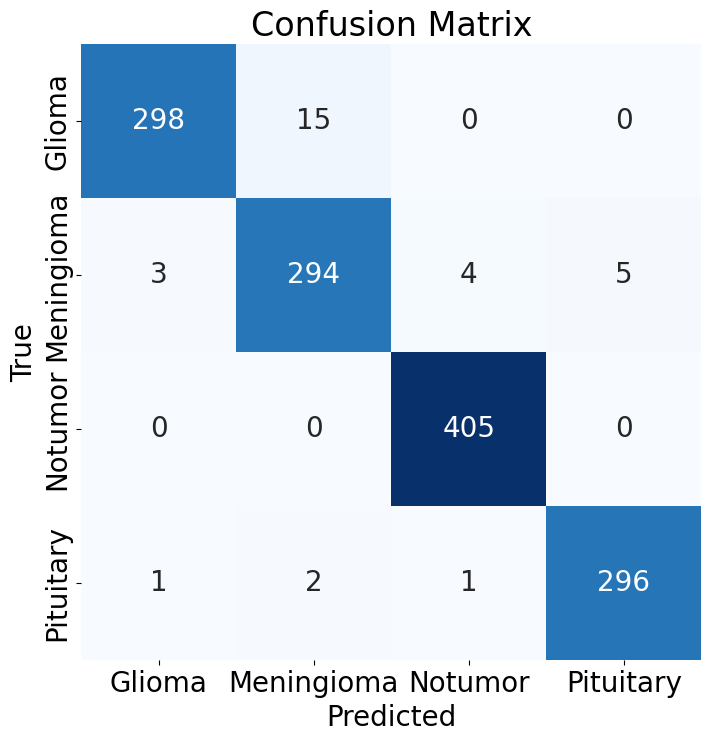

In [ ]:
confusion_matrix = CM(CNN_model=model, test_generator=test_generator, categories=class_indices_train_list)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], ha='center')
plt.yticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], va='center')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


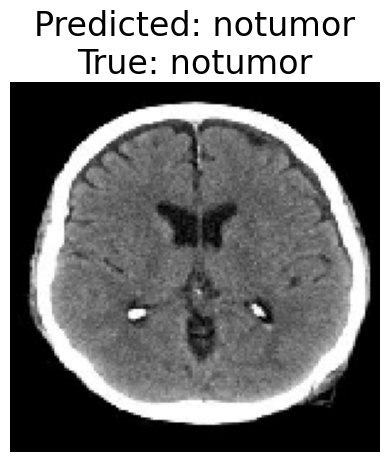

True Label: notumor
Predicted Label: notumor
Prediction Probabilities: [1.4348589e-12 6.5093875e-11 1.0000000e+00 7.0001730e-14]


In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img

image_path = test_paths[2]
true_label = test_labels[2]

# Make a prediction
predictions = model.predict(img_array)
predicted_class = np.argmax(predictions, axis=1)[0]

# Get the class name
class_names = list(test_generator.class_indices.keys())
predicted_label = class_names[predicted_class]

# Display the image and results
plt.imshow(array_to_img(img_array[0]))
plt.title(f"Predicted: {predicted_label}\nTrue: {true_label}")
plt.axis("off")
plt.show()

# Print the results
print(f"True Label: {true_label}")
print(f"Predicted Label: {predicted_label}")
print(f"Prediction Probabilities: {predictions[0]}")